# SLT-CE-7: Mean Field Approximation

**Solve the main part of the exercise to get 1 point. Solve the extension as well to get 2 points.**

# References 

[1] [Lecture slides](https://ml2.inf.ethz.ch/courses/slt/lectures/slt18_lecture06.pdf)

[2] [Exercises](https://ml2.inf.ethz.ch/courses/slt/exercises/exercise10.pdf)

[3] [Wine data set](http://archive.ics.uci.edu/ml/datasets/Wine)

[4] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

[5] [An Introduction to Variational Methods for Graphical Models](https://people.eecs.berkeley.edu/~jordan/papers/variational-intro.pdf)


# Image denoising using mean field approximation

## Task

We will be using the Ising model from the coding exercise 2 for image denoising, also described in Series 10 [2]. Recall that the model orignates from section 8.3.3 of [4]. However, to approximate the inference, instead of using MCMC, we will apply mean field approximation and then compare it to the MCMC estimates.

## Setup

We start by importing necessary python packages.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve
import time

We load the original image of size 300x300 which we will be trying to reconstruct. White pixels have values -1 and the black pixels are of value +1.

In [2]:
IMG_ORIGINAL = mpimg.imread("flower.png")#[:,:,0]/255
IMG_ORIGINAL[IMG_ORIGINAL > 0.5] = 1
IMG_ORIGINAL[IMG_ORIGINAL <= 0.5] = -1

Check the dimensions of the image

In [3]:
IMG_HEIGHT = IMG_ORIGINAL.shape[0]
IMG_WIDTH = IMG_ORIGINAL.shape[1]
IMG_ORIGINAL.shape

(300, 300)

Plot the original image

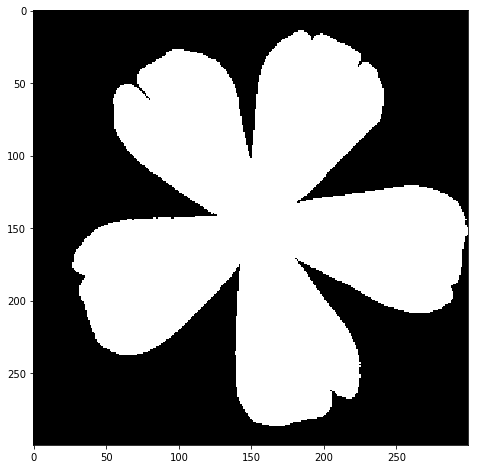

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_ORIGINAL, cmap='gray')
plt.show()

Generate the noisy version - flip random 30% of pixels. 

In [5]:
# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION = IMG_ORIGINAL.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

perm = np.random.permutation(IMG_ORIGINAL.size)[0:int(0.2 * IMG_ORIGINAL.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION[i,j] = -IMG_NOISY_OBSERVATION[i,j]

Plot the noisy version of the original image

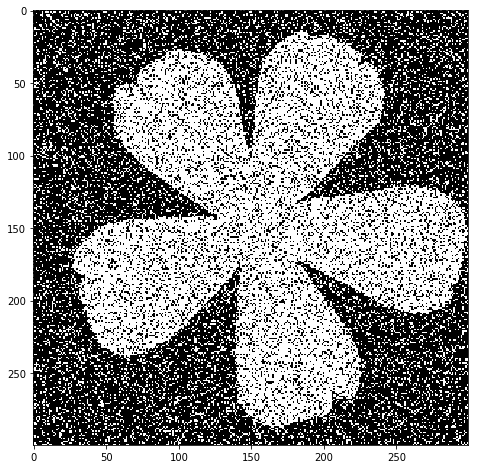

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(IMG_NOISY_OBSERVATION, cmap='gray')
plt.show()

We will fix the parameters of the model as given in [2].

In [7]:
H = 0.0
Beta = 1.0
Eta = 2.1

Global computation of the energy

In [8]:
def energy(img_estimate, img_noisy_observation, H = 0.0, Beta = 1.0, Eta = 2.1):
    """Compute the energy for given estimate 'img_estimate'
    with respect to the  observation 'img_noisy_observation'.

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
            energy (float): energy of the estimate given observation
    """
    kernel = np.asarray([[1,1,1],[1,0,1],[1,1,1]])
    neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)
    return - np.sum(H * img_estimate + \
                    Eta * img_estimate * img_noisy_observation + \
                    Beta * img_estimate * neigh_sum)

Estimating loss via mean squared error

In [9]:
def mse_loss(img_estimate, img_original):
    """Computing mean squared error loss

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_original (np.ndarray): original image matrix

    Returns:
            mse (float): mean squared error between two matrices
    """
    err = np.sum((img_estimate.astype("float") - img_original.astype("float")) ** 2)
    err /= float(img_estimate.shape[0] * img_estimate.shape[1])
    return err

Auxiliary function for the local energy computation of the implemented MCMC method.

In [10]:
def pixel_energy(img_estimate, img_noisy_observation, i, j):
    """Compute the energy localized around a pixel (i,j)

    Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix
            i,j (double, double): pixel coordinates

    Returns:
            energy (float): local energy around given pixel
    """
    return - ( H*img_estimate[i,j]+\
               Beta*img_estimate[i,j]*np.sum(img_estimate[i-1:i+2,j-1:j+2])+\
               Eta*img_estimate[i,j]*img_noisy_observation[i,j])

Display various energies and losses for the noisy image as our initial estimate with respect to the original image.

In [11]:
print(mse_loss(IMG_NOISY_OBSERVATION, IMG_ORIGINAL))
print(energy(IMG_ORIGINAL, IMG_NOISY_OBSERVATION))
print(energy(IMG_NOISY_OBSERVATION, IMG_NOISY_OBSERVATION))

0.8
-811248.0
-440895.9


## Problem 0

Describe the basics of the mean field approximation: <br>

The calculation of the partition function of the Gibbs distribution for a general cost function is not always possible due to the exponantially many terms. <br>

Motivated by this observation, the mean field approximation tries to obtain an approximative solution by minimizing an upper bound on the Gibbs energy. This upper bound is derived by the KL divergence between the real Gibbs distribution and the approximative Gibbs distribution: <br>

$$ D(Q || P) = \sum_{x \in \Omega} p(x) log \frac{p(x)}{q(x)} \geq 0$$

inserting the real Gibbs distribution:

$$ P(c) = \text{exp}(-\beta (R(c) - F))$$

and the approximate Gibbs distribution:

$$ Q(c, \theta) = \prod_{i \leq n} q_i(c(i))$$

leads to, after some simplifications:

$$ F \leq \frac{1}{\beta} \sum_{s\leq n} \sum_{\nu \leq k} q_s(\nu) log q_s(\nu) + \mathbb{E}_{\textbf{Q}}(R(c))$$

Minimizing this equation w.r.t. $q_i(\nu)$ leads to

$$ q_{u}(\alpha) = \frac{e^{-\beta (h_{u \, \alpha})}}{\sum_{\nu \leq k} e^{-\beta (h_{u \, \nu})}}$$

By veryfing that the second variations remain positive, one arrives at following updating scheme for the distribution and the meanfields: <br>

$$ q_{s(t)}^{New} = \frac{e^{-\beta (h_{s(t) \alpha})}}{\sum_{\nu \leq k} e^{-\beta (h_{s(t) \nu})}}$$
$$ h_{s(t) \alpha} = \mathbb{E}_{Q_{s(t) \rightarrow \alpha}^{Old}} (R(c))$$


## Problem 1

With the help of [2], explain the algorithm for solving image denoising using mean field approximation: <br>

Starting from the mean field upper bound

$$ G(p) = KL(p_o || p) / \beta + F(\beta) $$

one can insert the definition of the KL divergence i.e. $KL(p_o || p) = \sum_\sigma p_0(\sigma) log( \frac{p_0(\sigma)}{p(\sigma)})$ and the definition of the Gibbs distribution i.e. $p(\sigma) = exp(-\beta ( E(\sigma)- F))$ which leads to:

$$ G(p) = \sum_\sigma p_0(\sigma) E(\sigma) + \frac{1}{\beta} \sum_\sigma p_0(\sigma) log p_0(\sigma) $$

In the next step, the distribution $p_0$ is explored.Assuming a proposal energy function of the form $E_0 = \sum_i \sigma_i h_i^{eff}$ and plugging into the proposal distribution:

$$ p_0(\sigma) = \frac{1}{Z} \prod_i exp(- \beta \sigma_i h_i^{eff})$$

where 

$$ Z = \prod_i [exp(- \beta h_i^{eff})+ exp( \beta h_i^{eff})] $$

Now, it is assumed that the proposal distribution can be written as:

$$ p_0(\sigma) = \prod_i^{N}  \frac{1+ \sigma_i m_i}{2}$$

where

$$ m_i = \frac{exp(- \beta h_i^{eff})- exp(\beta h_i^{eff})}{exp(- \beta h_i^{eff})+ exp(\beta h_i^{eff})}$$

Inserting $m_i$ and the energy for the image denoising i.e. $ E(\sigma) = \lambda \sum_{i= 1} ^N h_i \sigma_i - \sum_{i,j=1}^N J_{ij} \sigma_i \sigma_j $ into the Gibbs energy function $G(p)$ yields upon symplifying:

$$ G(p) = -\lambda \sum_{k} m_k h_k - \sum_{i=1}^{N-1} \sum_{j= i+1}^N m_i J_{ij} m_j + \frac{1}{\beta} \sum_{i=1}^{N} \bigg[ \frac{1+ m_i}{2} log\frac{1+ m_i}{2} + \frac{1- m_i}{2} log\frac{1- m_i}{2}\bigg]$$

The next step is minimizing the upper bound given by the Gibbs energy. This is done by taking the derivative w.r.t. $m_i$ yielding:

$$ m_k = tanh \big[ \beta( \sum_{i\neq k} J_{ki} m_i + \lambda h_k )\big]$$

For denoising the image, one can loop over the individual pixels and update the value by the above expression for $m_k$. The free parameters are the Kernel $J_{ki}$, which defines the size of the neighborhood taken into account and $\lambda$, a paramter for the weighting between the influence of the noisy pixel value $h_k$ and the denoised neighborhood $m_i$ on the update of pixel $k$.

## Problem 2

Implement mean field algorithm for image denoising. You are provided with an implementation of the metropolis algorithm as a representative of MCMC, for the sake of comparison. Note that the epochs parameter below is introduced solely to ease the plotting procedure and it is up to you assign the semantics to it.

Evaluate your mean field implementation using 'evaluate' function, and compare your results to MCMC. Clearly explain the differences. Does it converge faster? What are the disadvantages and advantages?

Consider running the comparison on another image to prove your point.

Also, feel free to replace our implementation of MCMC with your own.

In [12]:
def metropolis(img_noisy_observation, img_original, epochs, H = 0.0, Beta = 1.0, Eta = 2.1, T = 1, wdw = 1):
    """Do the metropolis sampling starting from the noisy observation as
    our initial estimate. Repeat sampling for a given number of epochs.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
   
    img_estimate = img_noisy_observation.copy()
    img_estimate_padded = np.pad(img_estimate, 1, mode='constant', constant_values=0)
    img_noisy_observation_padded = np.pad(img_noisy_observation, 1, mode='constant', constant_values=0)

    energy_vals = []
    loss = []

    for e in range(epochs):
        for i in range(1,img_original.shape[0]+1):
            for j in range(1,img_original.shape[1]+1):
                # calculate local energy
                pixel_cur_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # flip the pixel
                img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                # calculate new local energy
                pixel_new_energy = pixel_energy(img_estimate_padded, img_noisy_observation_padded, i, j)
                # energy difference
                dE = pixel_new_energy - pixel_cur_energy
                # do metropolis thingy
                if dE > 0:
                    p = 0.5*(1-np.tanh(0.5 / T * dE))
                    rr = np.random.rand(1)
                    if rr > p:
                        # revert back pixel
                        img_estimate_padded[i,j] = -img_estimate_padded[i,j]
                    # append energy
                if j % 200 == 0:
                    energy_vals.append(energy(img_estimate_padded[1:-1,1:-1],img_noisy_observation))
                    loss.append(mse_loss(img_estimate_padded[1:-1,1:-1],img_original))

    return img_estimate_padded[1:-1,1:-1], np.asarray(energy_vals), np.asarray(loss)

In [13]:
def meanfield(img_noisy_observation, img_original, epochs, H = 0.0, Beta = 1.0, Eta = 2.1, T = 1, wdw = 1):
    """Do the meanfield approximation to estimate the reconstruction.

    Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
                - Note: we use it only so we can keep track of the
                  MSE drop i.e. for the plotting purposes.
            epochs (int): number of iterations

    Returns:
            img_estimate (np.ndarray): return reconstucted estimate of the original
            energies (np.ndarray): energies recorded in arbitary moments during 
                                      the sampling process, for plotting purposes
            losses (np.ndarray): MSE loss wrt original image recorded in arbitary 
                                 moments during the sampling process, for plotting purposes
    """
    img_estimate = img_noisy_observation.copy()
    img_denoised = img_noisy_observation.copy()

    energy_vals = []
    loss = []
    
    kernel = np.ones([2* wdw+ 1, 2* wdw+ 1])
    kernel[wdw, wdw] = 0    
    
    # repeat
    for e in range(epochs):
        
        neigh_sum = convolve(img_estimate, kernel, mode="constant", cval=0)

        img_estimate = np.tanh(1/T* (Beta* neigh_sum+ Eta* img_noisy_observation))
        
        energy_vals.append(energy(img_estimate, img_noisy_observation, H, Beta, Eta))
        loss.append(mse_loss(img_estimate, img_original))
    
    return img_estimate, np.asarray(energy_vals), np.asarray(loss)

In [14]:
def evaluate(method, img_noisy_observation, img_original, epochs=1, H = 0.0, Beta = 1.0, Eta = 2.1, T = 1, wdw = 1):
    """ Given an inference method, we will run the estimation procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling
    """
    # Run specified sampling method
    start_time = time.time()
    img_estimate, energies, losses = method(img_noisy_observation, img_original, epochs, H, Beta, Eta, T, wdw)
    execution_time = time.time() - start_time
    # Plot energy and MSE drop
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    ax1.plot(energies)
    ax1.set_title('Energy Drop')
    ax2.plot(losses)
    ax2.set_title('MSE Loss Drop')
    ax3.imshow(img_estimate, cmap='gray')
    ax3.set_title('Reconstruction')
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    plt.suptitle("Executed in approx. "+str(int(execution_time)) + " seconds")
    # show plots
    plt.show()

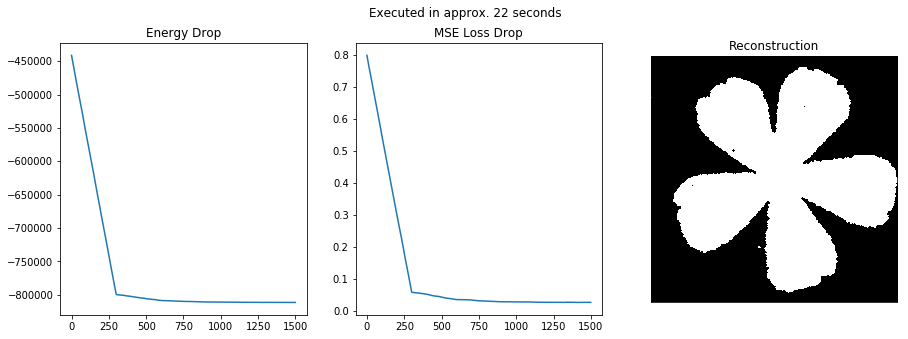

In [15]:
evaluate(metropolis, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 5)

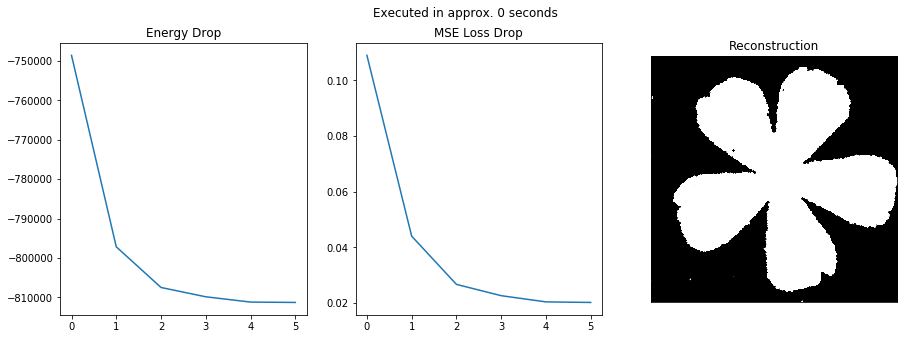

In [16]:
# Evaluate your imlementation of the meanfield
evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 6)

Compare and analyze performance:

The mean field approximation is more than an order of magnitude faster than the Metropolis sampling. This is mainly due to the efficiency of the convolve method (mean field )compared to the slow loop over each individual pixel and the calculation of the new and old local energy to derive the acceptance of a change (Metropolis). <br>

However, we were able to simplify significantly the equations for the mean field approximation due to the problem setting (ising model). Generally, one would have to carry out an EM algorithm, which would be considerably slower than the here derived analytical expression for the update. <br>

Concerning the accuracy, both algorithm yield very similar results rendering both a valid choice from this point of view. <br>

Concerning the convergence, Metropolis requires fewer iterations over the complete image than mean field (~1-2 for Metropolis vs. ~3-4 for mean field)

Any implementation/computational/numerical issues?

## Problem 3

Comment on the convergence of the method. How can we tell if the mean field converged? Do we always reach the global optimum? <br>

The mean field approximation update scheme will converge to a local minimum of the approximate free energy in the space of factorial distributions. (concerning the global optimum)<br>

The Ginzburg criterion is a quantitative measure about when mean field theory is valid, which is the case as long as one is able to neglect fluctuations in the system under consideration. (concerning the general validity of mean field)<br>

Convergence can be checked by looking at the energy drop and enfocing a bound (concerning when it is converged)

$$ |E_{final}- E(t)| \leq \epsilon \qquad \forall T \leq t $$


## Problem 4

How do the parameters of the Ising model, and the temperature affect the performance of the mean field?

Plot image reconstructions for different settings of the model parameters (at least 10 experiments). Also, plot the reconstruction with varying parameters of the mean field algorithm. Can you explain the behaviour?

Beta= 0.3


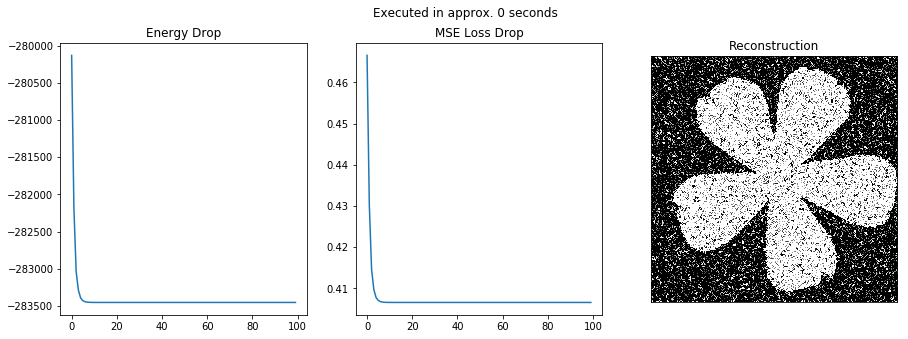

Beta= 0.5


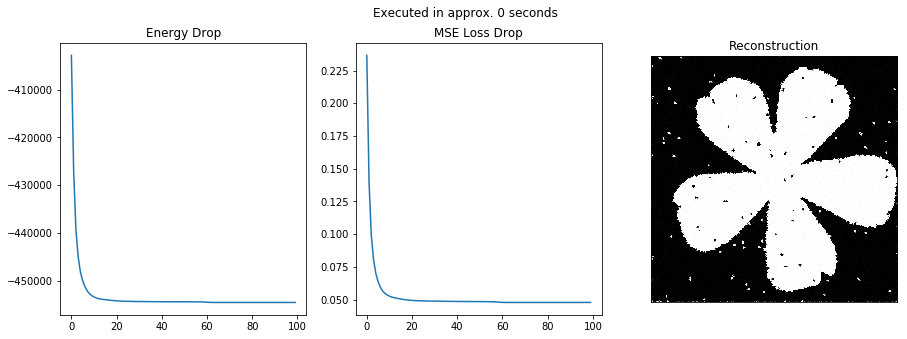

Beta= 0.8


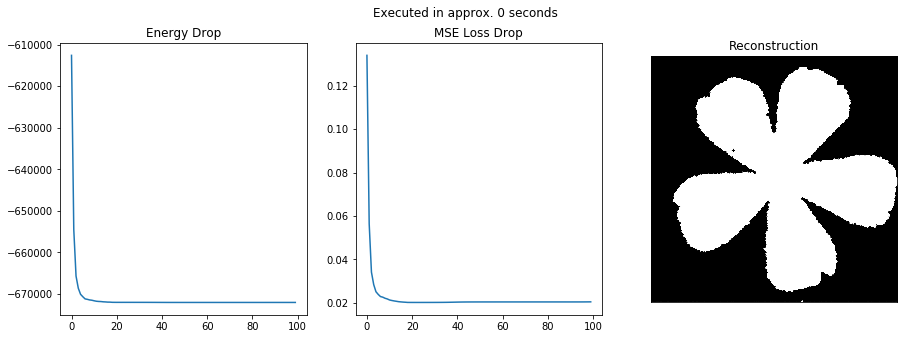

Beta= 1


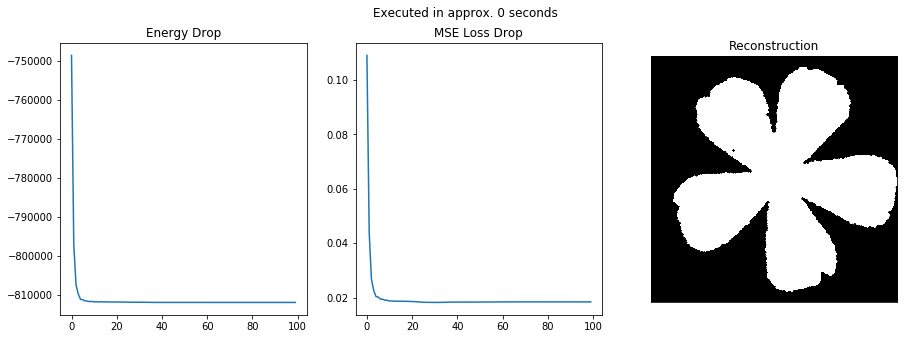

Beta= 10


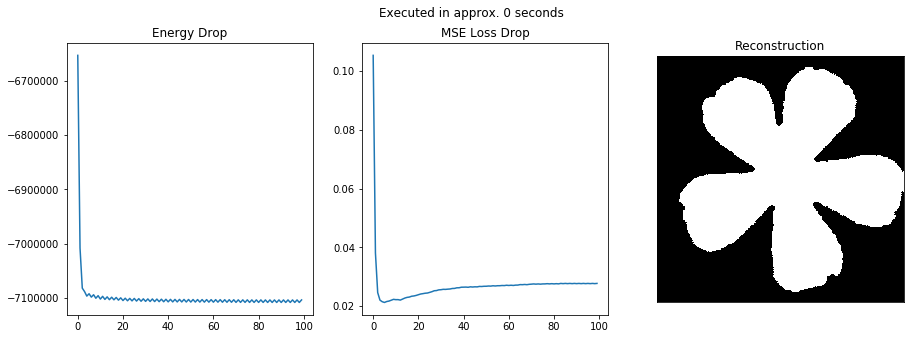

Beta= 20


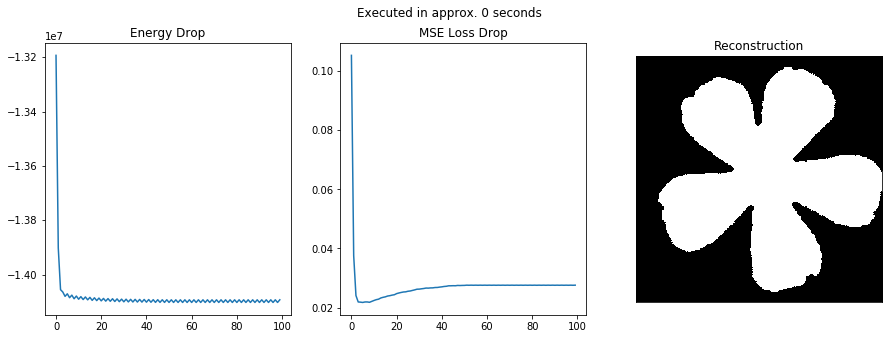

Beta= 50


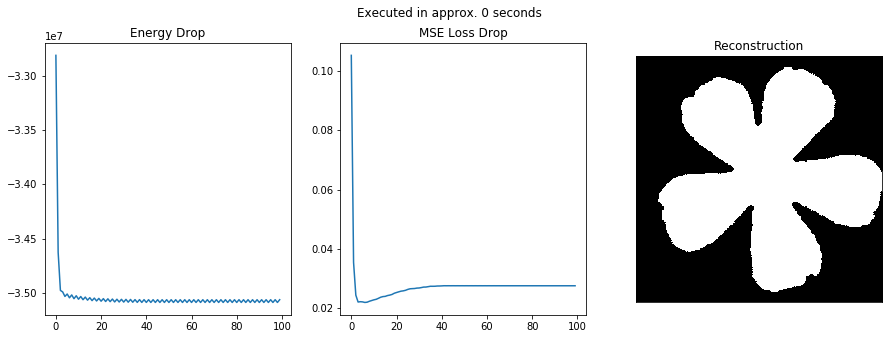

Beta= 100


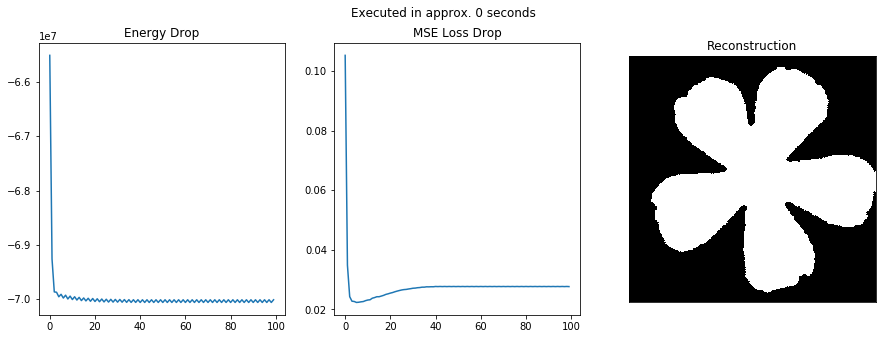

Beta= 10000.0


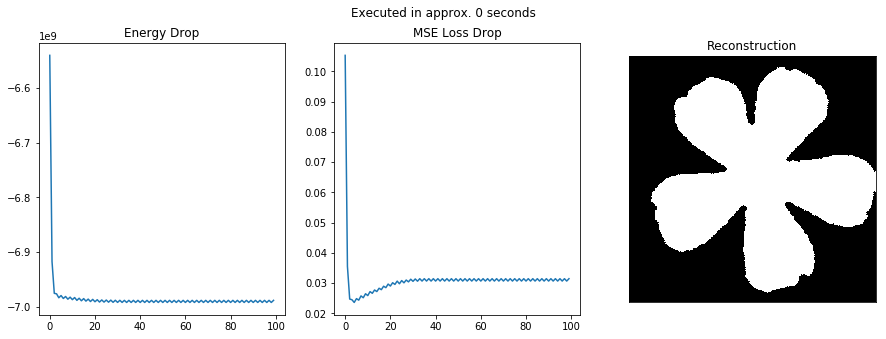

In [17]:
# model parameter
Beta = 1.0
Eta = 2.1

# mean field paramter
T = 1
wdw = 1 # kernel width -> J: [2* wdw+ 1, 2* wdw+ 1]

# what matters in the end is the ratio between Beta and Eta
beta_list = [0.3, 0.5, 0.8, 1, 10, 20, 50, 100, 1e4]
for Beta in beta_list:
    print('Beta= '+ str(Beta))
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 100, 0, Beta, Eta, T, wdw)

For small $\beta$ values, a very small weight is assigned to the influence of the neighboring pixels and the assignment is almost solely determined by the noisy value of the current pixel. This leads to the situation that in the limiting case $\beta \rightarrow 0$ no denoising takes place. <br>

Contrarily, for increasing values of $\beta$, the importance of the neighborhood increases up to a point at which the assignment is solely determined by the assignment in the neighborhood. This leads to a very robust denoising as can be seen in the figures.

T= 0.001


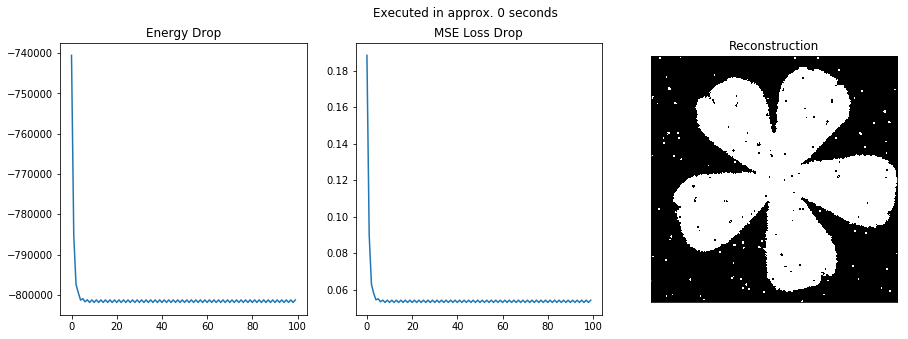

T= 0.01


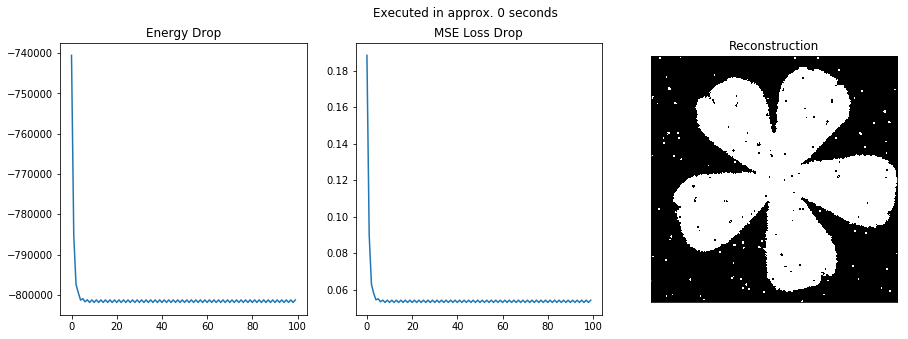

T= 0.1


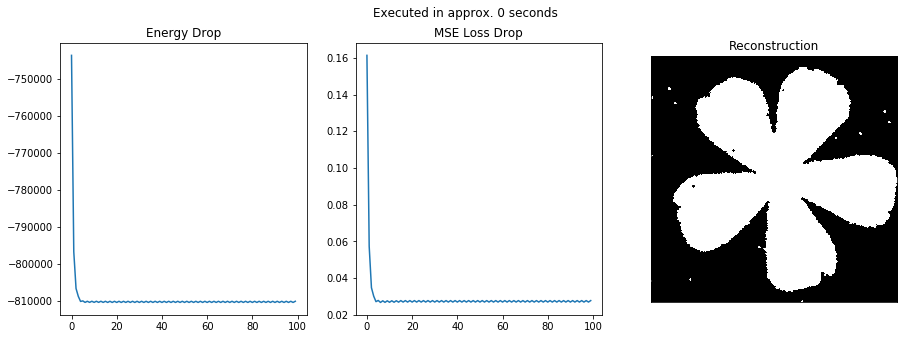

T= 1.0


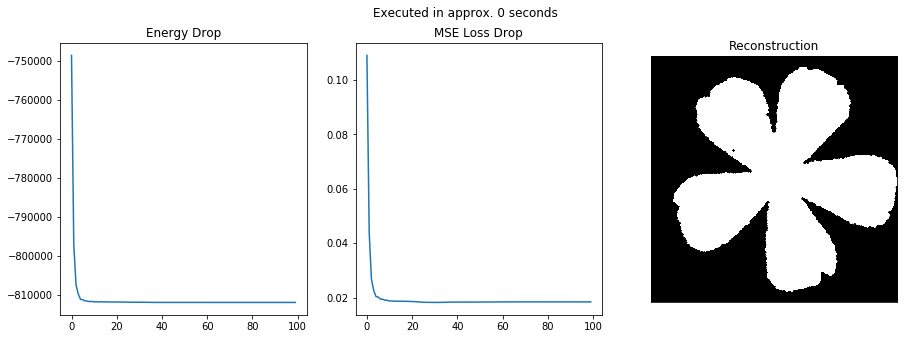

T= 10.0


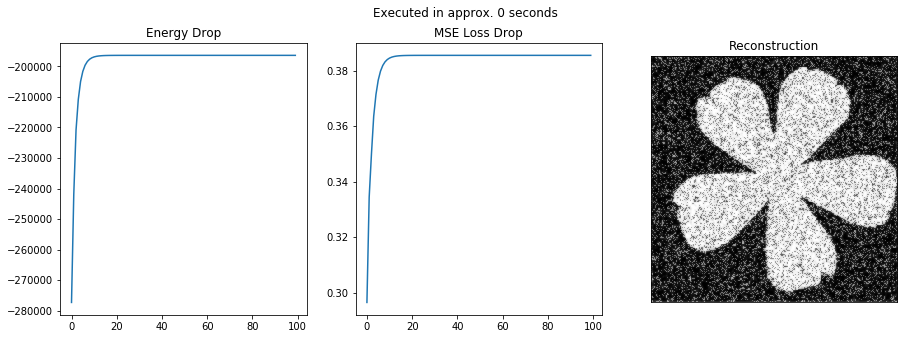

T= 100.0


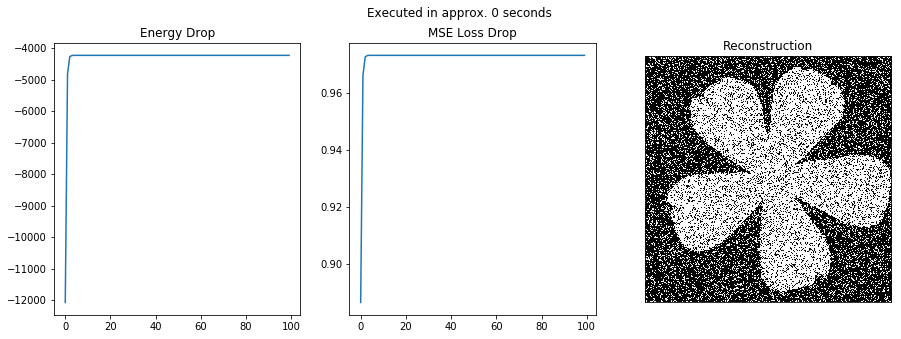

T= 1000.0


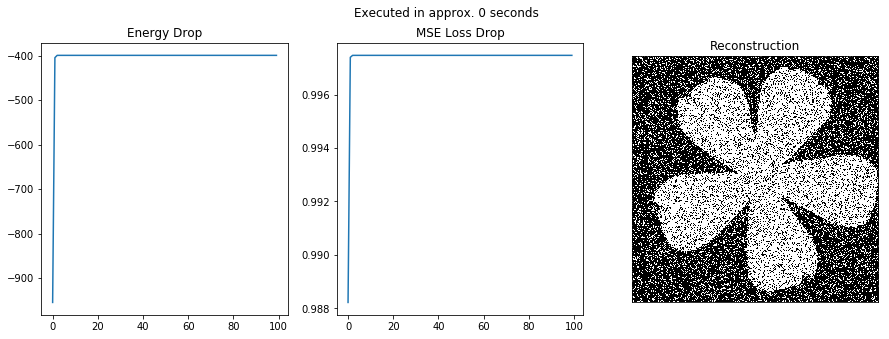

In [18]:
# model parameter
Beta = 1.0
Eta = 2.1

# mean field paramter
T = 1
wdw = 1 # kernel width -> J: [2* wdw+ 1, 2* wdw+ 1]

# vary temperature
T_list = np.power(10, np.linspace(-3, 3, 7))
for T in T_list:
    print('T= '+ str(T))
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 100, 0, Beta, Eta, T, wdw)

The temperature influences the coarseness of the solution space. At high temperatures, the algorithm searches through the solution space ignoring small features of the energy function. As a result, the assignment:

$$ m_k = tanh \bigg( \frac{1}{T}(\sum_{i \neq k} J_{ki} m_i + \lambda h_k) \bigg)$$

is not very robust (as $T \rightarrow \infty$ the arg(tanh) $\rightarrow 0$ thus tanh $\rightarrow 0$), yielding values close to zero not improving the solution as small disturbances leads to almost randomly switching the sign of pixels. <br>

For low temperatures, the algorithm is attracted to a local minima with the assignment giving values close to minus one or one (as $T \rightarrow \pm 0$ the arg(tanh) $\rightarrow \pm \infty$ thus tanh $\rightarrow \pm 1$), respectively. Hence, the assignment is more robust.


Kernel size= 3 x 3


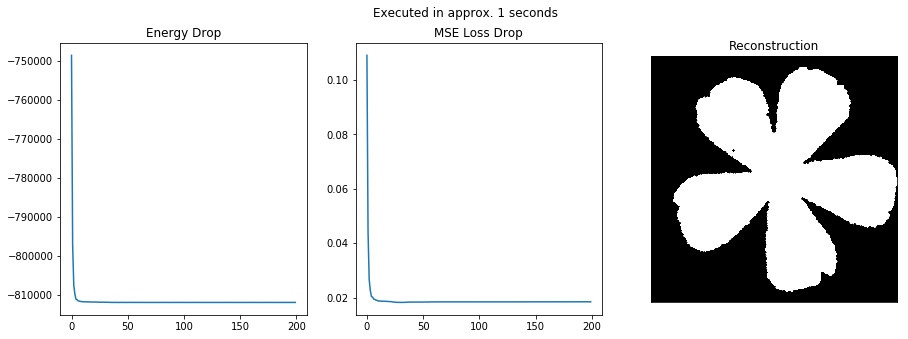

Kernel size= 5 x 5


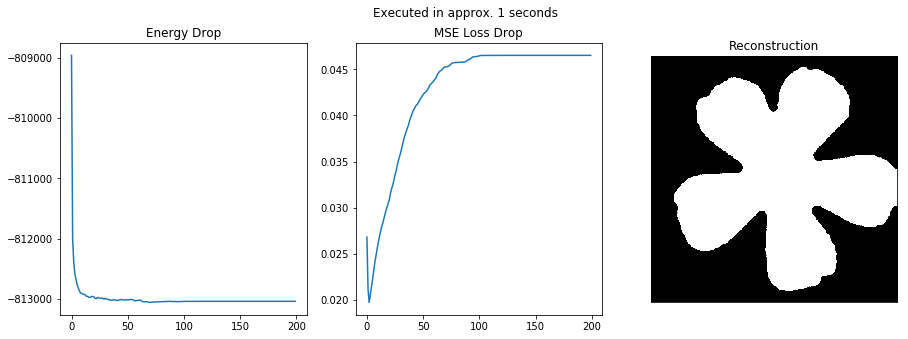

Kernel size= 7 x 7


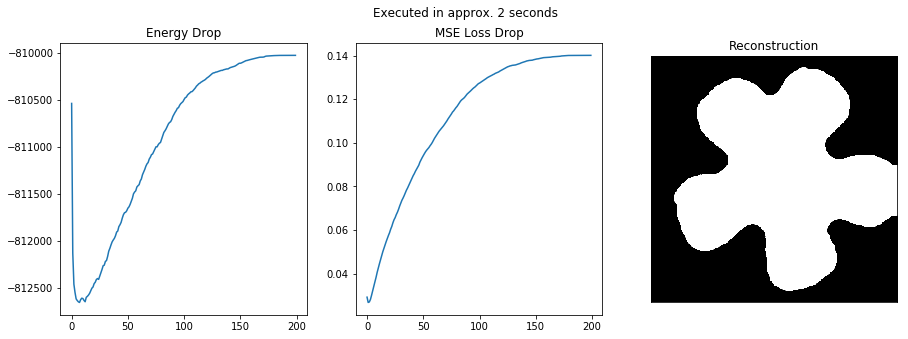

Kernel size= 9 x 9


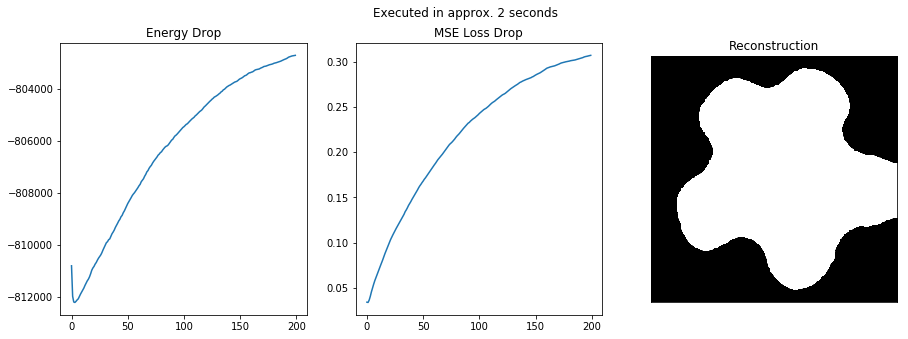

Kernel size= 11 x 11


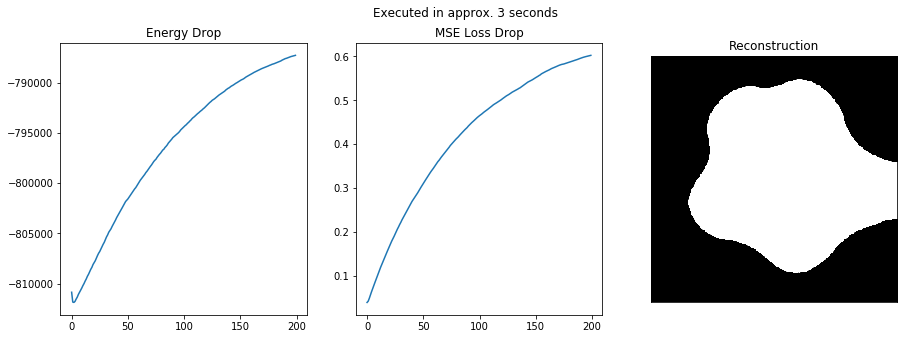

In [19]:
# model parameter
Beta = 1.0
Eta = 2.1

# mean field paramter
T = 1
wdw = 1 # kernel width -> J: [2* wdw+ 1, 2* wdw+ 1]

# vary temperature
wdw_list = [1, 2, 3, 4, 5]
for wdw in wdw_list:
    print('Kernel size= '+ str(2*wdw+ 1)+ ' x '+ str(2* wdw+ 1))
    evaluate(meanfield, IMG_NOISY_OBSERVATION, IMG_ORIGINAL, 200, 0, Beta, Eta, T, wdw)

The larger the kernel, the smoother gets the decision boundary since more and more neighboring pixels are taken into account when updating the assignment. This leads to a smirring out of the boundaries. On the other hand, larger kernels are more robust against local noise, which is shown by the noise still present for a kernel size of 3x3 whereas for kernel sizes greater or equal to 5x5 the noise is completely cancelled.

To sum up, it is important to choose an appropriate temperature in order to be able to explore the solution space but allow for a reasonable convergence of the algorithm. A small kernel size together with a large $\beta$ parameter allow to properly denoise the image while preserving clear boundaries.

## Problem 5

Is there something specific to the given image, which makes it more suitable for one or the other method? Feel free to use another image to prove your point? <br>

The boundaries of the cloverleaf are very smooth without sharp edges except at the root of the individual leafes. This seems to be an advantage for both methods since they rely on a kernel function, which leads to "smirred" boundaries as has been prove above (increasing the kernel size). A nice visualization is shown for the checkerboard further down, where the texture is not properly reconstructed. <br>

There are a few differences of the two algorithms: <br>
1) The Metropolis algorithm requires to design a proposal distribution with the assumption of independence between the data <br>
2) The Metropolis algorithm allows also for exploration of the solution space by the acceptance probability, where the trade-off is set by the temperature.

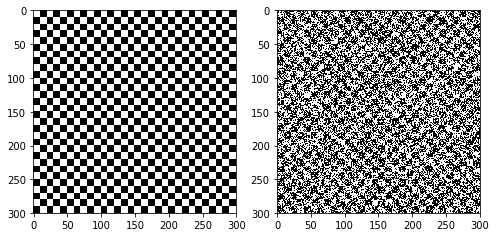

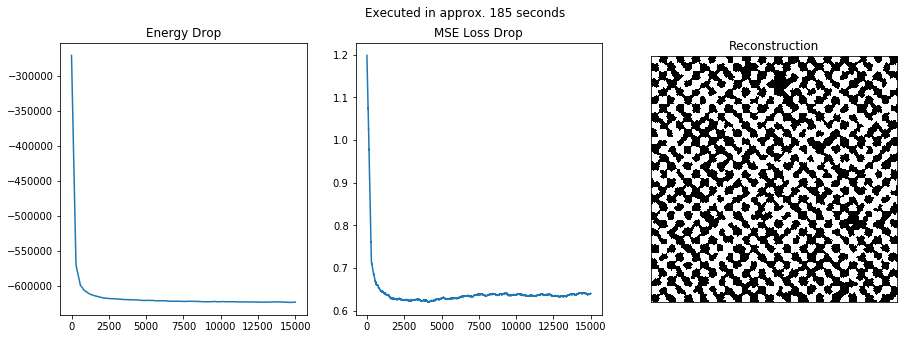

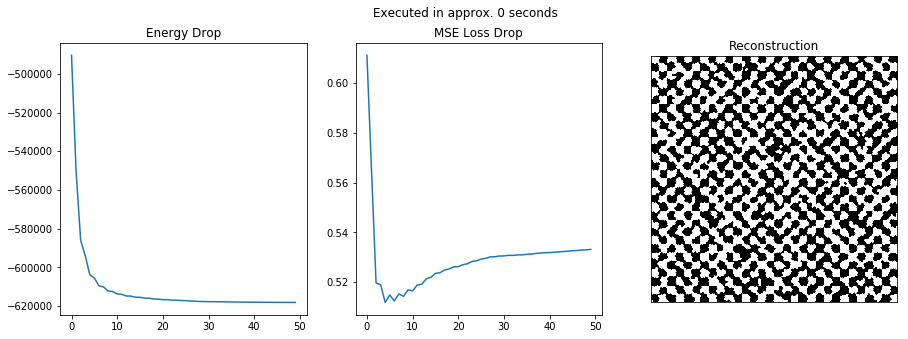

In [20]:
# generate checkerboard
IMG_ORIGINAL2 = np.zeros([300, 300])

checker_size = 10

for i in range(IMG_ORIGINAL2.shape[0]):
    for j in range(IMG_ORIGINAL2.shape[1]):
        IMG_ORIGINAL2[i, j] = 1- 2*((int(i/checker_size)+ int(j/ checker_size)) %2)

# image shape
IMG_HEIGHT = IMG_ORIGINAL2.shape[0]
IMG_WIDTH = IMG_ORIGINAL2.shape[1]
IMG_ORIGINAL2.shape

# Fix random seed for reproducibility
np.random.seed(13)

IMG_NOISY_OBSERVATION2 = IMG_ORIGINAL2.copy()
num_flips = int(0.3 * IMG_HEIGHT * IMG_WIDTH)

# permute pixel
perm = np.random.permutation(IMG_ORIGINAL2.size)[0:int(0.3 * IMG_ORIGINAL2.size)]
for k in perm:
    i = int(k/IMG_WIDTH)
    j = k%IMG_HEIGHT
    IMG_NOISY_OBSERVATION2[i,j] = -IMG_NOISY_OBSERVATION2[i,j]
    
# plot noisy image
fig, ax = plt.subplots(1, 2, figsize = (8, 16))
ax[0].imshow(IMG_ORIGINAL2, cmap='gray')

# plot original image
ax[1].imshow(IMG_NOISY_OBSERVATION2, cmap='gray')
plt.show()

# model parameter
Beta = 1.0
Eta = 2.1

# mean field paramter
T = 1
wdw = 1 # kernel width -> J: [2* wdw+ 1, 2* wdw+ 1]

evaluate(metropolis, IMG_NOISY_OBSERVATION2, IMG_ORIGINAL2, 10)
evaluate(meanfield, IMG_NOISY_OBSERVATION2, IMG_ORIGINAL2, 50, 0, Beta, Eta, T, wdw)

# Extension: Smooth k-means

For this part of the task please use the Wine data set (different one than before, see [3]). It contains three classes, see more detailed description online. Implement both, plain-vanilla k-means and smooth k-means [1] and compare them on the Wine data set.

Implementation:

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


df = pd.read_csv("wine_new.csv")
X = df.values[:, 1:]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
y_true = np.int16(df.values[:, 0])-1
print(X.shape)

print(np.bincount(y_true))

(177, 13)
[58 71 48]


In [22]:
def kmeans(X, n_clusters = 3):
    
    # variable keeping track of assignments
    y = np.zeros([X.shape[0]])
    
    # initialize cluster centers
    mean = np.zeros([n_clusters, X.shape[1]])
    
    for k in range(n_clusters):
        mean[k] = X[np.random.randint(X.shape[0])]
    
    while True:
        mean_old = mean
        
        # M
        for k in range(X.shape[0]):
            dist = np.sum((X[k] - mean)**2, axis = 1)

            y[k] = np.argmin(dist)
    
        # E
        for k in range(n_clusters):
            mean[k] = np.sum(X[np.where(y == k)])
            
        if np.allclose(mean, mean_old, atol = 1e-3):
            break
    
    return mean, np.int16(y)

In [23]:
from sklearn.neighbors import NearestNeighbors as kNN
from functools import reduce

def smooth_kmeans(X, n_clusters = 3, n_neighbors = 5, lam = 1e-3):
    beta = 1
    
    # initialization ---------------------------------------------
    # assignment probability
    q = np.random.rand(X.shape[0], n_clusters)
    
    for k in range(X.shape[0]):
        q[k]/= np.sum(q[k])
        
    # mean fields
    h = np.zeros([X.shape[0], n_clusters])
    
    # cluster centers calculated by soft-assignment
    y = np.zeros([n_clusters, X.shape[1]])
    
    for k in range(n_clusters):
        y[k] = np.dot(q[:, k].T, X)      
        
    # k NN for each data point required in EM algorithm
    nbrs = kNN(n_neighbors = n_neighbors, algorithm='ball_tree').fit(X)
    _, indices = nbrs.kneighbors(X)
    
    while True:
        y_old = y
    
        for k in range(X.shape[0]):
            # E
            for j in range(n_clusters):
                nu = [i for i in range(n_clusters) if i != j]
                #               ||x_u - y_alpha||             sum_(j in N) \sum_(v<k, v != alpha) q_j(v)
                h[k, j] = np.dot(X[k]- y[j], (X[k]- y[j]).T)+ lam* np.sum(q[indices[k]][:, nu])

            # M
            q[k] = np.exp( -beta* h[k]- reduce(np.logaddexp, -beta* h[k], -np.Inf))

        # mean
        for k in range(n_clusters):
            y[k] = np.dot(q[:, k].T, X)
            
        # convergence
        if np.allclose(y, y_old, atol = 1e-3):
            break
        
    return q, y, np.argmax(q, axis = 1)

In [37]:
# run kmeans and smooth kmeans
_, y_kmeans = kmeans(X)
_, _, y_EM = smooth_kmeans(X, lam = 10)

Visualize the clustering by embedding the data to 2D and indicate the labeling by k-means compared
to the ground truth.

Text(0,0.5,'dimension 2')

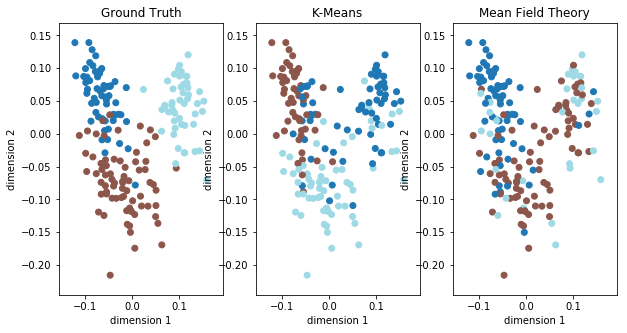

In [38]:
from sklearn.decomposition import PCA

cm = plt.get_cmap('tab20', 3)

# dimensionality reduction
pca_kp = PCA(n_components= 2)
pca_kp.fit(X.T)
        
embeddings = pca_kp.components_
 
# plot clusters with color indicated labels in 2 dimensions
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
ax[0].scatter(embeddings[0, :], embeddings[1, :], c= y_true, cmap = cm)
ax[0].set_title('Ground Truth')
ax[0].set_xlabel('dimension 1')
ax[0].set_ylabel('dimension 2')

ax[1].scatter(embeddings[0, :], embeddings[1, :], c= y_kmeans, cmap = cm)
ax[1].set_title('K-Means')
ax[1].set_xlabel('dimension 1')
ax[1].set_ylabel('dimension 2')

ax[2].scatter(embeddings[0, :], embeddings[1, :], c= y_EM, cmap = cm)
ax[2].set_title('Mean Field Theory')
ax[2].set_xlabel('dimension 1')
ax[2].set_ylabel('dimension 2')

Use the available labels (1-3) to assess the cluster purity and comment on the observed vs. the expected
effect of smooth k-means.

In [39]:
from scipy.optimize import linear_sum_assignment

def permute_prediction(C_pred, C_true):
    """ Permute labels in predicted labels such that they denote the same clusters as in L_true

    Args:
        C_pred (np.ndarray): Predicted clusters shape (N,)
        C_true (np.ndarray): True clusters shape (N,)

    Returns:
        C_permuted (np.ndarray): Permuted clusters
    """
    n_clusters = int(np.max(C_true) + 1)
    
    # 
    I = np.eye(n_clusters,dtype='int')
    MP = I[C_pred]
    MT = I[C_true]
    
    # MO(i,j) is the cost of assigning cluster i in L_pred to cluster j in L_true
    MO = - MP.T @ MT

    # find best permutation using the hungarian algorithm
    # ie permute rows in MP to have minimum trace of MP.T @ MT.
    row_ind, col_ind = linear_sum_assignment(MO)
    
    P = np.zeros((n_clusters,n_clusters),dtype='int')
    P[col_ind, row_ind] = 1
                 
    #MO = - P @ MP.T @ MT
    
    # 
    C_permuted = np.argmax(P @ MP.T, axis=0)
    
    return np.reshape(C_permuted, C_pred.shape), P 

In [40]:
y_kmeans_permuted, _ = permute_prediction(y_kmeans, y_true)
y_EM_permuted, _ = permute_prediction(y_EM, y_true)

# calculate cluster purity
cluster_purity_kmeans = 1/X.shape[0]* np.count_nonzero(y_kmeans_permuted == y_true)
cluster_purity_smooth_kmeans = 1/X.shape[0]* np.count_nonzero(y_EM_permuted == y_true)

# print results in [%]
print('Cluster purity K-Means= '+ str(int(1000* cluster_purity_kmeans)/ 10)+ ' %')
print('Cluster purity smooth K-Means= '+ str(int(1000* cluster_purity_smooth_kmeans)/ 10)+ ' %')

Cluster purity K-Means= 71.7 %
Cluster purity smooth K-Means= 68.3 %


First of all, it needs to be noted that the results of the K-Means and the smoothed K-Means vary widely between the different runs. In the implementation in sklearn, this issue is addressed by running the k-means algorithm multiple times (10 by default) with varying initial seedings and keeping the best model in terms of momentum. This procedure could be implemented in a further step and would improve robustness. <br>

Generally, one would think that smooth k-means would lead to more concise clusters enforcing locally the assignment of data points to the same cluster. However, in the example here this can not be observed and K-means as well as smooth k-means yield very similar purity values (but note that they vary widely between the different realisations as described above and the algorithm have to be run multiple times to get a good picture of what is going on)

Evaluate the BIC score for both algorithms (make use of the meanfield-approximation for smooth
k-means). Does it indicate 3 clusters?

In [28]:
def BIC_kmeans(X, y, mu, n_clusters = 3):
    # according to https://github.com/bobhancock/goxmeans/blob/master/doc/BIC_notes.pdf
    M = X.shape[1] # dimensions
    R = X.shape[0] # elements
    K = n_clusters # clusters
    
    l_model_dep = 0
    l_model_indep = 0

    for k in range(K):
        l_model_dep+= len(np.where(y== k)[0]) * np.log(len(np.where(y== k)[0]))
    
    var= 1/(M* (R- K))* np.sum([np.dot(X[i]- mu[y[i]], (X[i]- mu[y[i]]).T) for i in range(R)])

    l_model_dep-= (M* K /2 -R* M/2* np.log(var))

    l_model_indep-= (M* R/ 2+ R* np.log(R)+ R* M/ 2* np.log(2* np.pi))

    BIC = l_model_dep + l_model_indep - M* K/ 2* np.log(R)
    
    return BIC
    

In [29]:
def BIC_smooth_kmeans(X, q, mu, n_clusters = 3):
    # according to https://github.com/bobhancock/goxmeans/blob/master/doc/BIC_notes.pdf
    M = X.shape[1] # dimensions
    R = X.shape[0] # elements
    K = n_clusters # clusters
    
    l_model_dep = 0
    l_model_indep = 0

    for k in range(K):
        l_model_dep+= np.sum(q[:, k]) * np.log(np.sum(q[:, k]))
    
    var= 1/(M* (R- K))* np.sum([np.dot(X[i]- np.dot(q[i], mu), (X[i]- np.dot(q[i], mu)).T) for i in range(R)])

    l_model_dep-= (M* K /2 -R* M/2* np.log(var))

    l_model_indep-= (M* R/ 2+ R* np.log(R)+ R* M/ 2* np.log(2* np.pi))

    BIC = l_model_dep + l_model_indep - M* K/ 2* np.log(R)
    
    return BIC

C:\Users\Roman\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Roman\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


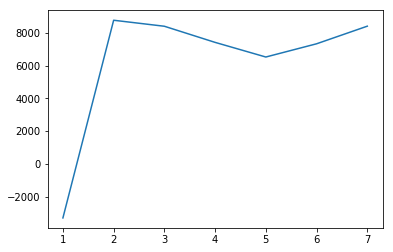

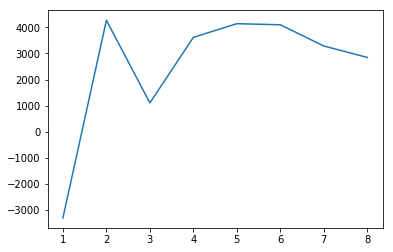

In [30]:
# evaluate optimum number of clusters
BIC_km = np.zeros([8])
BIC_smooth_km = np.zeros([8])

for n in range(1, 9):
    mu, y_kmeans = kmeans(X, n_clusters = n)
    BIC_km[n- 1] = BIC_kmeans(X, y_kmeans, mu, n_clusters = n)
    
    q, mu, y_smooth_kmeans = smooth_kmeans(X, n_clusters = n)       
    BIC_smooth_km[n- 1] = BIC_smooth_kmeans(X, q, mu, n_clusters = n)
    
    
plt.figure()
plt.plot(np.arange(1, 9), BIC_km)
plt.show()

plt.figure()
plt.plot(np.arange(1, 9), BIC_smooth_km)
plt.show()

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in this box. This will help us improve our exercises. Thank you in advance!

Less open-questions as e.g. what are the advantages and disadvantages or comment on the results. $\rightarrow$ It is very hard to know what you expect in terms of keywords and also in terms of amount as one could basically write pages about the different aspects of each algorithm. <br>

I would prefer questions of the type: <br>
Analyse your algorithm in terms of a, b, c (1-2 sentence(s) for each point). <br>
This gives us a hint into which direction to go and also what you expect.